## Table Of Contents
 1. [Analisi esplorativa con `PCA`, `ICA`, `t-SNE`](#esplorativa)
 2. [Modello multinomiale](#multinomiale)<br>
     2.1 [Modello multinomiale penalizzato](#multinomiale-pen)
 3. [Analisi discriminante](#lda-qda)<br>
     3.1 [Analisi discriminante penalizzata](#da-pen)
 4. [Alberi di regressione](#tree)<br>
     4.1 [Alberi di regressione penalizzati](#tree-penalized)<br>

END. [Salvataggio dei dati](#save)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Funzioni base:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tqdm

# Font di LaTeX
# from matplotlib import rc

# Scikit-Learn
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# Funzioni custom
from funzioni import AbsMeanVarDeriv, Whiten,ScatterGroup, MatriceConfusione, indice_gini, DistGroup
from funzioni import tasso_errata_classificazione, grafico_metrica_iperparametro, grafico_metrica_iperparametri
from funzioni.grafici import grafico_importanza_variabili

# 1. Analisi esplorativa con `PCA`, `ICA`, `t-SNE` <a id=esplorativa> </a>

In [3]:
PATH_DATA = './PhonePi/data/'
FIG_PATH = './figure/'
DIR = [os.path.join(PATH_DATA, o) for o in os.listdir(PATH_DATA) 
                    if os.path.isdir(os.path.join(PATH_DATA,o))]
tipo=[(dir.split("/")[-1]).split(".")[0] for dir in DIR]
tipo=[dir.split("-")[0] for dir in tipo]

In [4]:
espl = pd.read_pickle("espl.pkl")
y = pd.read_pickle("y-2s.pkl")
X_train = pd.read_pickle("X_train.pkl")
y_train = pd.read_pickle("y_train.pkl")
X_val = pd.read_pickle("X_val.pkl")
y_val = pd.read_pickle("y_val.pkl")

In [5]:
X_train.shape

(2541, 6)

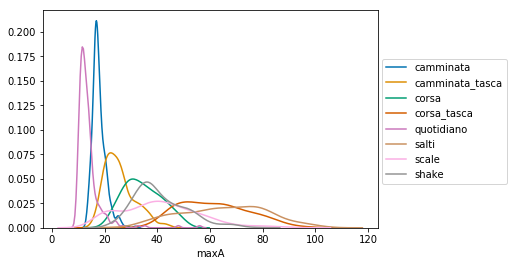

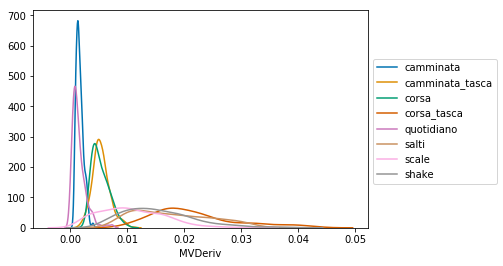

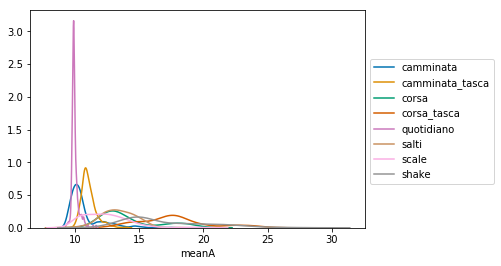

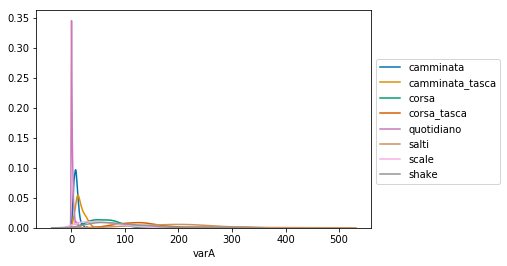

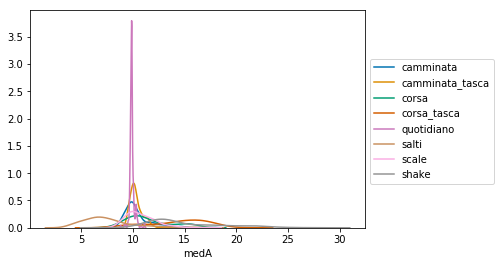

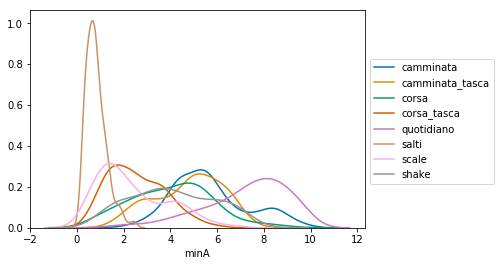

In [55]:
for col in X_train.columns:
    DistGroup(X_train[col], grp=y, leg_loc = (1.4, 0.8),
              palette="colorblind", file = FIG_PATH + col + ".png")

In [7]:
# Sbiancamento dei dati
esplWh = Whiten().fit_transform(espl)

pca = PCA(n_components=2, random_state=42)
esplPCA = pca.fit_transform(esplWh)

ica = FastICA(n_components=2, random_state=42)
esplICA = ica.fit_transform(esplWh)

tsne = TSNE(n_components=2, random_state=42)
esplTSNE = tsne.fit_transform(esplWh)

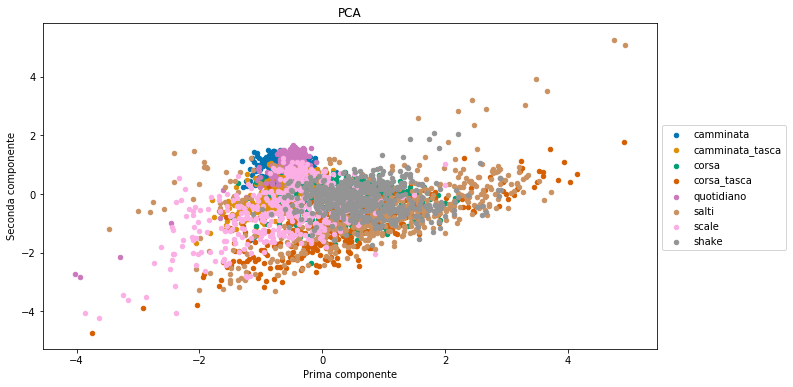

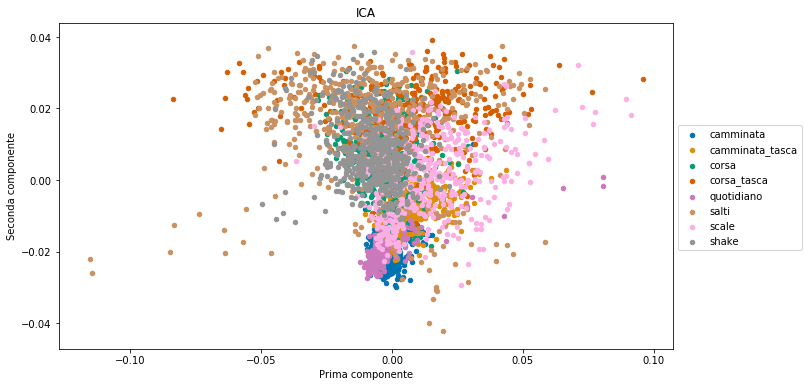

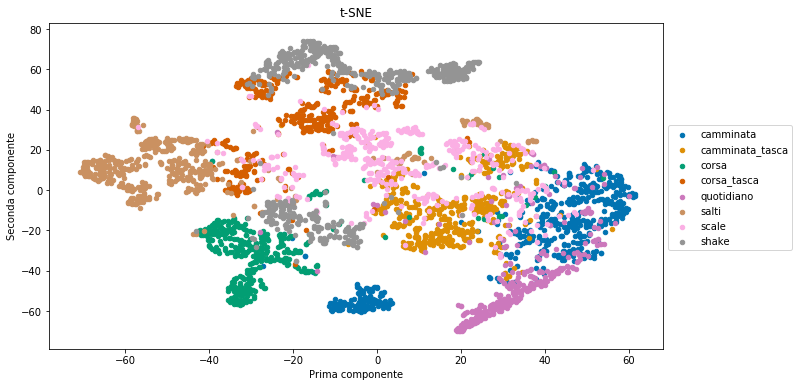

In [8]:
for title,dat in zip(["PCA","ICA","t-SNE"], [esplPCA, esplICA, esplTSNE]):
    fig, ax = ScatterGroup(pd.DataFrame(dat, columns=["Prima componente", "Seconda componente"]),
                       grp=y, palette="colorblind")
    fig.set_figwidth(11)
    fig.set_figheight(6)
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1,0.7))
    plt.savefig(FIG_PATH+title+".png", bbox_inches="tight", dpi=180)

# 2. Modello multinomiale <a id=multinomiale> </a>

Regressione multinomiale: 86.1% di accuratezza


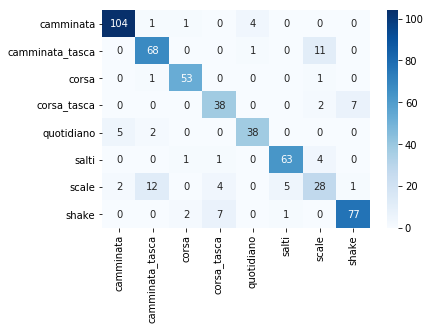

In [74]:
glmMult = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, multi_class="multinomial",
                             solver="newton-cg", max_iter=300)
fit = glmMult.fit(X_train, y_train)
y_pred = fit.predict(X_val)

acc_mn = 100*accuracy_score(y_val, y_pred)
print("Regressione multinomiale: {:.1f}% di accuratezza".format(acc_mn))
MatriceConfusione(y_val, y_pred, nome_immagine=FIG_PATH+"confusionMatrix-Mn.png",)

## 2.1 Modello multinomiale penalizzato <a id=multinomiale-pen></a>

In [10]:
fit.classes_

array(['camminata', 'camminata_tasca', 'corsa', 'corsa_tasca',
       'quotidiano', 'salti', 'scale', 'shake'], dtype=object)

In [11]:
lab = y.unique()
lab.sort()
print(lab)

['camminata' 'camminata_tasca' 'corsa' 'corsa_tasca' 'quotidiano' 'salti'
 'scale' 'shake']


In [12]:
def PesiShakeMn(val):
    '''
    Funzione per modificare i pesi nel modello multinomiale
    
    Parameters
    ----------
    Modello : Funzione di classificazione (LDA o QDA)
    
    val : array di valori per cui dividere il peso base della classe shake
    '''
    iteraz = []
    lista_acc=[]
    lista_veri_positivi=[]
    for i in tqdm.tqdm(val):
        iteraz.append(i)
        weights = y_train.value_counts()/y_train.value_counts().sum()
        weights["shake"]/=i
        weights/=weights.sum()
        w = {ind:weights[ind] for ind in weights.index}
        model = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, 
                               multi_class="multinomial",solver="newton-cg", max_iter=100, class_weight=w)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        lista_acc.append(100*accuracy_score(y_val, y_pred))
        lista_veri_positivi.append(100*(confusion_matrix(y_val, y_pred, labels=lab)[-1,-1]/confusion_matrix(y_val, y_pred,labels=lab)[:,-1].sum()))
        
    return iteraz, lista_acc, lista_veri_positivi

In [83]:
import warnings
warnings.filterwarnings("ignore")
pesi = np.arange(1, 13, 0.5)
iteraz, lista_acc_mn, lista_veri_positivi_mn = PesiShakeMn(val=pesi)

100%|██████████| 24/24 [00:29<00:00,  1.23s/it]


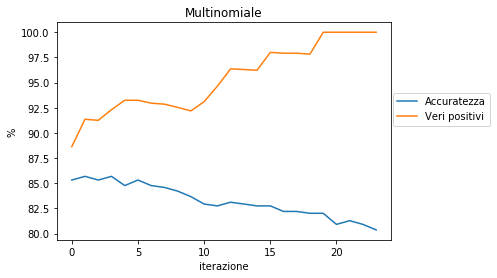

In [84]:
plt.plot(lista_acc_mn, label = "Accuratezza")
plt.plot(lista_veri_positivi_mn, label = "Veri positivi")
plt.title("Multinomiale")
plt.xlabel("iterazione")
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.31,0.7))

plt.show()

Accuratezza Multinomiale penalizzata: 82.0%


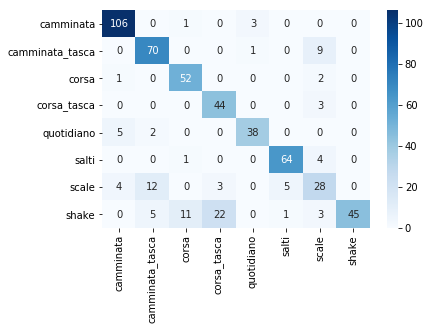

In [85]:
i = pesi[lista_veri_positivi_mn.index(100)]
weights = y_train.value_counts()/y_train.value_counts().sum()
weights["shake"]/=i
weights/=weights.sum()
w = {ind:weights[ind] for ind in weights.index}
model = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, 
                               multi_class="multinomial",solver="newton-cg", max_iter=100, class_weight=w)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
acc_mn_pen = 100*accuracy_score(y_val, y_pred)
print("Accuratezza Multinomiale penalizzata: {:.1f}%".format(acc_mn_pen))
MatriceConfusione(y_val, y_pred,nome_immagine=FIG_PATH+"confusionMatrix-Mn-penalizzata")

In [16]:
#-------------------- TODO ---------------------#
# Prendere il peso migliore per la multinomiale #
#-----------------------------------------------#
#w = ...


#glmMult = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, multi_class="multinomial",
#                              solver="newton-cg", max_iter=300, class_weight=w)
#fit = glmMult.fit(X_train, y_train)
# y_pred = fit.predict(X_val)

# acc_mn_pen = 100*accuracy_score(y_val, y_pred)
# print("Regressione multinomiale penalizzata: {:.1f}% di accuratezza".format(acc_mn_pen))
# MatriceConfusione(y_val, y_pred)
# plt.savefig(FIG_PATH+"confusionMatrix-Mn-penalizzata.png", dpi=300, bbox_inches="tight")

# 3. Analisi discriminante lineare e quadratica <a id=lda-qda> </a>

Accuratezza LDA: 72.7%


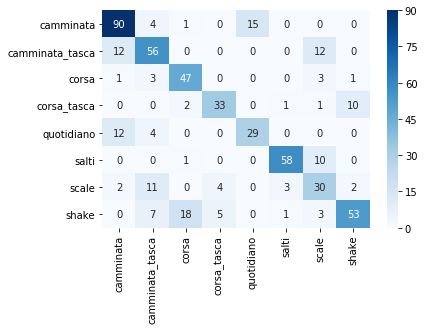

In [17]:
lda = LinearDiscriminantAnalysis()
X_lda=lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_val)
acc_lda = 100*accuracy_score(y_val, y_pred_lda)
print("Accuratezza LDA: {:.1f}%".format(acc_lda))
MatriceConfusione(y_val, y_pred_lda,nome_immagine=FIG_PATH+"confusionMatrix-LDA")

Accuratezza QDA: 85.9%


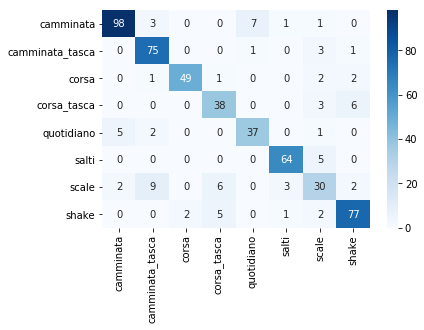

In [18]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA: {:.1f}%".format(acc_qda))
MatriceConfusione(y_val, y_pred_qda,nome_immagine=FIG_PATH+"confusionMatrix-QDA")

## 3.1 Analisi discriminante penalizzata <a id=da-pen> </a>

In [19]:
print(lda.classes_)

['camminata' 'camminata_tasca' 'corsa' 'corsa_tasca' 'quotidiano' 'salti'
 'scale' 'shake']


In [20]:
def PesiShakeDA(Modello, val):
    '''
    Funzione per modificare i pesi delle analisi discriminanti lineare e quadratica.
    
    Parameters
    ----------
    Modello : Funzione di classificazione (LDA o QDA)
    
    val : array di valori per cui dividere il peso base della classe shake
    '''

    lista_acc=[]
    lista_veri_positivi=[]
    w=[]
    for i in val:
        weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
        weights[-1] /= i
        weights = weights/weights.sum()
        w.append(weights[-1])
        model = Modello(priors=weights)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        lista_acc.append(100*accuracy_score(y_val, y_pred))
        lista_veri_positivi.append(100*(confusion_matrix(y_val, y_pred, labels=lab)[-1,-1]/confusion_matrix(y_val, y_pred,labels=lab)[:,-1].sum()))
        
    return w, lista_acc, lista_veri_positivi

### LDA e QDA penalizzate

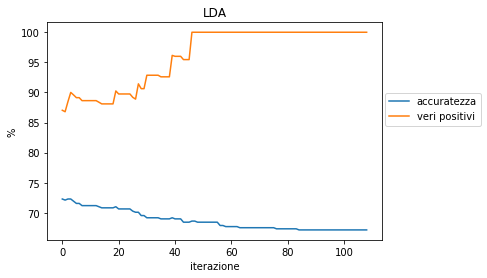

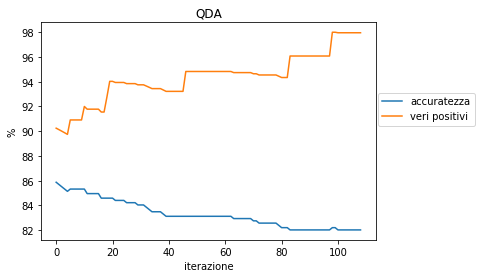

In [21]:
# in pratica per pesi crescenti assegnati alla classe dello shake si nota che la percentuale di veri positivi aumenta
# e l'accuratezza ovviamente diminuisce. Se vogliamo che l'errore di classificare shake qualcosa che non è shake sia nullo
# (o <0.01) scegliamo il primo peso che mi porta ad avere veri_positivi uguale a 100 (o 99) in modo da scegliere 
# il modello con l'accuratezza migliore fra quelli che non sbagliano lo shake

val = np.arange(1.1, 12, 0.1) # lista di divisori del peso per la classe

pesi_lda, lista_acc_lda, lista_veri_positivi_lda = PesiShakeDA(LinearDiscriminantAnalysis, val)
plt.plot(lista_acc_lda, label = "accuratezza")
plt.plot(lista_veri_positivi_lda, label = "veri positivi")
plt.title("LDA")
plt.xlabel("iterazione")
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.31,0.7))
plt.show()

pesi_qda, lista_acc_qda, lista_veri_positivi_qda = PesiShakeDA(QuadraticDiscriminantAnalysis, val)
plt.plot(lista_acc_qda, label = "accuratezza")
plt.plot(lista_veri_positivi_qda, label = "veri positivi")
plt.title("QDA")
plt.xlabel("iterazione")
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.31,0.7))
plt.show()

In [22]:
lista_veri_positivi_qda[-1]

97.95918367346938

In [23]:
lista_veri_positivi_lda=np.array(lista_veri_positivi_lda)
num_iterazione_lda=np.min(np.where(lista_veri_positivi_lda>99))
peso_shake_lda=np.arange(1.1,12,0.1)[num_iterazione_lda]
peso_shake_lda

5.700000000000005

In [78]:
lista_veri_positivi_qda=np.array(lista_veri_positivi_qda)
num_iterazione_qda=np.min(np.where(lista_veri_positivi_qda>97))
peso_shake_qda=np.arange(1.1,12,0.1)[num_iterazione_qda]
peso_shake_qda

10.900000000000007

Accuratezza LDA penalizzata: 68.6%


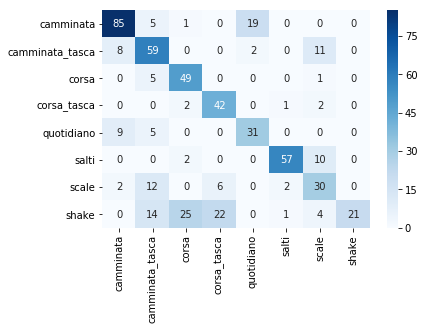

In [26]:
weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
weights[-1] /= peso_shake_lda
weights = weights/weights.sum()
lda = LinearDiscriminantAnalysis(priors=weights)
X_lda=lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_val)
acc_lda_pen = 100*accuracy_score(y_val, y_pred_lda)
print("Accuratezza LDA penalizzata: {:.1f}%".format(acc_lda_pen))
MatriceConfusione(y_val, y_pred_lda, nome_immagine=FIG_PATH+"confusionMatrix-LDA-penalizzata")

Accuratezza QDA penalizzata: 82.2%


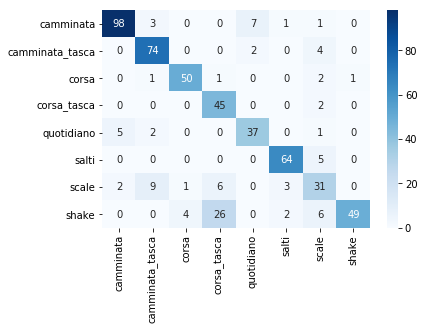

In [27]:
weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
weights[-1] /= peso_shake_qda
weights = weights/weights.sum()
qda = QuadraticDiscriminantAnalysis(priors=weights)
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda_pen = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA penalizzata: {:.1f}%".format(acc_qda_pen))
MatriceConfusione(y_val, y_pred_qda,nome_immagine=FIG_PATH+"confusionMatrix-QDA-penalizzata")

# 4. Alberi di regressione <a id=tree> </a>

Accuratezza DecisionTreeClassifier(): 82.57%


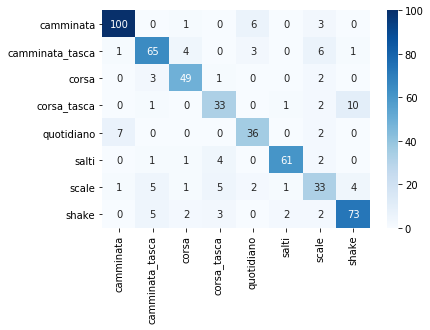

In [28]:
# Albero stimato sul training, senza vincoli (albero completo)
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_val)
acc_dtcFull = 100*accuracy_score(y_val, y_pred)

print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(acc_dtcFull))
MatriceConfusione(y_val, y_pred)
plt.show()

In [29]:
maxDepth = dtc.tree_.max_depth
minObs = len(X_train) // 2
print("Profondità dell'albero allenato senza restrizioni: {}".format(maxDepth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(minObs))

Profondità dell'albero allenato senza restrizioni: 21
Massimo numero minimo di osservazioni in una foglia: 1270


In [30]:
param_grid = ParameterGrid({
    'max_depth': np.arange(1, dtc.tree_.max_depth+1),
    'min_samples_leaf': 2 ** np.arange(int(np.log2(minObs) + 1)),
})
print(param_grid.param_grid)

[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21]), 'min_samples_leaf': array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024])}]


In [31]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc = DecisionTreeClassifier(random_state=42, **params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|██████████| 231/231 [00:01<00:00, 130.58it/s]

Primi 5:


,accuracy_score,max_depth,min_samples_leaf
0,0.829358,19,1
1,0.827523,14,1
2,0.825688,10,1
3,0.825688,11,1
4,0.825688,12,1


Ultimi 5:


,accuracy_score,max_depth,min_samples_leaf
226,0.354128,17,1024
227,0.354128,18,1024
228,0.354128,19,1024
229,0.354128,20,1024
230,0.354128,21,1024


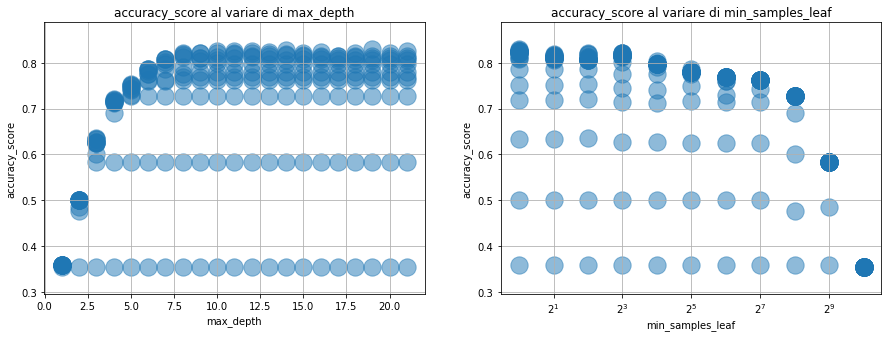

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
grafico_metrica_iperparametro(risultati, "max_depth", "accuracy_score", alpha=0.5)

plt.subplot(122)
grafico_metrica_iperparametro(risultati, "min_samples_leaf", "accuracy_score", alpha=0.5)
plt.xscale("log", basex=2)

plt.show()

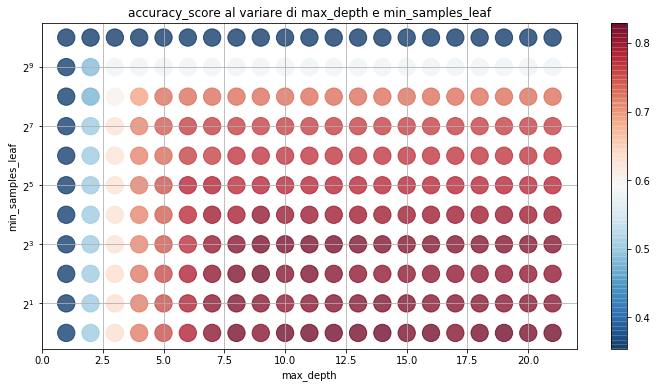

In [33]:
plt.figure(figsize=(12, 6))

grafico_metrica_iperparametri(risultati, "max_depth", "min_samples_leaf", "accuracy_score")
plt.yscale("log", basey=2)
plt.savefig(FIG_PATH + "iperparametri-Tree.png", dpi=200)
plt.show()

In [34]:
max_depth = risultati.loc[0, "max_depth"]
min_samples_leaf = risultati.loc[0, "min_samples_leaf"]

dtcTun = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
dtcTun.fit(X_train, y_train)

y_pred = dtcTun.predict(X_val)
acc_dtcTun = 100*accuracy_score(y_val, y_pred)
print("profondità ottimale:",max_depth)
print("numero ottimale minimo di unità per foglia:",min_samples_leaf)

profondità ottimale: 19
numero ottimale minimo di unità per foglia: 1


Accuratezza DecisionTreeClassifier(): 82.6%
Accuratezza DecisionTreeClassifier(max_depth=19, min_samples_leaf=1): 82.9%
[[100   0   1   0   6   0   3   0]
 [  1  68   3   0   1   0   6   1]
 [  0   3  49   1   0   0   2   0]
 [  0   1   0  35   0   1   0  10]
 [  7   1   0   0  36   0   1   0]
 [  0   1   1   3   0  62   2   0]
 [  1   6   1   6   2   2  31   3]
 [  0   5   2   5   0   2   2  71]]


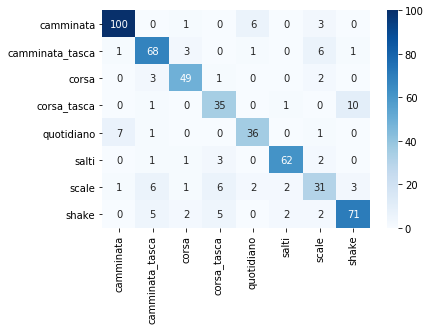

<Figure size 432x288 with 0 Axes>

In [35]:
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(acc_dtcFull))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, acc_dtcTun))
print(confusion_matrix(y_val, y_pred))

MatriceConfusione(y_val, y_pred)
plt.savefig(FIG_PATH + "confusionMatrix-Tree.png", dpi=300, bbox_inches="tight")
plt.show()

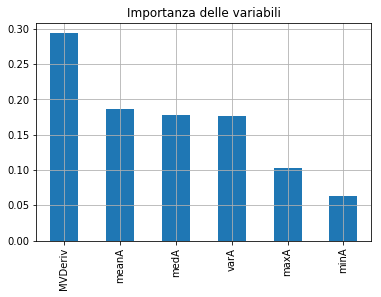

In [36]:
importanze = dtcTun.feature_importances_
variabili = espl.columns

grafico_importanza_variabili(importanze, variabili)
plt.savefig(FIG_PATH + "importance-Tree.png", dpi=300, bbox_inches="tight")
plt.show()

## 4.1 Alberi di regressione penalizzati  <a id=tree-penalized> </a>

In [37]:
dtc.classes_

array(['camminata', 'camminata_tasca', 'corsa', 'corsa_tasca',
       'quotidiano', 'salti', 'scale', 'shake'], dtype=object)

In [38]:
i=20
weights = y_train.value_counts()/y_train.value_counts().sum()
weights["shake"]/=i
weights/=weights.sum()
w = {ind:weights[ind] for ind in weights.index}

Accuratezza DecisionTreeClassifier(): 83.7%


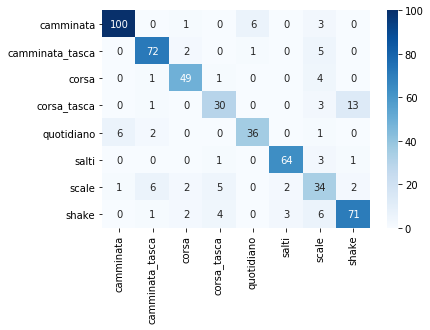

In [39]:
dtc = DecisionTreeClassifier(random_state=42,
                             class_weight=w)

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_val)
acc_dtc_pen = 100*accuracy_score(y_val, y_pred)
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(acc_dtc_pen))
MatriceConfusione(y_val, y_pred)

# END. Salvataggio dei risultati <a id=save> </a>

## Tabella accuracy in file LaTeX

In [40]:
def DataFrameToTable(df, file, cap="", lab="", digits="%.2f"):
    '''
    Funzione che stampa un dataframe in tabella di LaTeX.
    
    Parametri
    ---------
    df : DataFrame
        DataFrame da stampare in tabella
        
    file : string
        Percorso completo al file in cui scrivere la tabella
        
    cap : string
        Caption per la tabella
    
    lab : string
        Label della tabella
    
    '''

    tableEnvBegin = "\\begin{table}[H]\n\\centering\n"
    tableEnvEnd = "\\end{table}"
    c = 1 if cap else 0
    l = 1 if lab else 0
    caption="\\caption{"*c + cap + "}\n"*c
    label="\\label{"*l + lab + "}\n"*l
        
    with open(file, mode="w") as f:
        f.write(tableEnvBegin + caption +
                   df.to_latex(index=False, float_format=digits, column_format="cc") +
                   label + tableEnvEnd)
    

In [50]:
accuracy = pd.DataFrame([["Multinomiale", acc_mn],
             ["LDA", acc_lda],
             ["QDA", acc_qda],
             ["Albero decisionale", acc_dtcFull],
             ["Albero decisionale ottimizzato", acc_dtcTun]], columns=["Modello", "Accuratezza %"])

accuracy.sort_values("Accuratezza %", inplace=True, ascending=False)


In [51]:
DataFrameToTable(accuracy, file = "./relazione/tex/accuracy-table.tex",
                cap = "Accuratezza per i modelli adattati sull'insieme di validazione.",
                lab = "tab:acc")

In [52]:
accuracy = pd.DataFrame([["Multinomiale", acc_mn_pen],
                         ["LDA", acc_lda_pen],
                         ["QDA", acc_qda_pen]],
                        columns=["Modello", "Accuratezza %"])
accuracy.sort_values("Accuratezza %", inplace=True, ascending=False)

DataFrameToTable(accuracy, file = "./relazione/tex/accuracy-table-pen.tex",
                 cap = "Accuratezza per i modelli adattati sull'insieme di validazione.",
                 lab = "tab:acc_pen")

### Crop delle immagini

In [90]:
import platform
if platform.system() == "Linux":
    !mogrify -trim ./figure/*.png

mogrify-im6.q16: geometry does not contain image `./figure/confusionMatrix-Dummy.png' @ warning/attribute.c/GetImageBoundingBox/247.
mogrify-im6.q16: geometry does not contain image `./figure/confusionMatrix-Tree.png' @ warning/attribute.c/GetImageBoundingBox/247.


In [87]:
X_test = pd.read_pickle("X_test.pkl")
y_test = pd.read_pickle("y_test.pkl")

Accuratezza Multinomiale sull'insieme di test: 82.0%


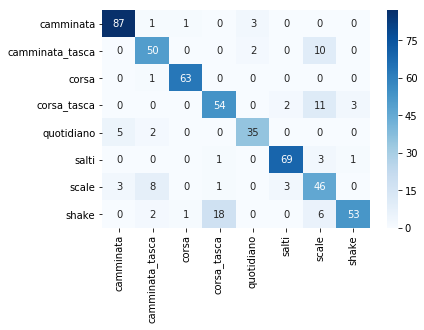

In [88]:
model = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, 
                               multi_class="multinomial",solver="newton-cg", max_iter=300, class_weight=w)
model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
y_pred = model.predict(X_test)
acc_mn_pen_test = 100*accuracy_score(y_test, y_pred)
print("Accuratezza Multinomiale sull'insieme di test: {:.1f}%".format(acc_mn_pen))
MatriceConfusione(y_test, y_pred,nome_immagine=FIG_PATH+"confusionMatrix-Mn-test")


Accuratezza QDA pesata sull'insieme di test: 83.5%


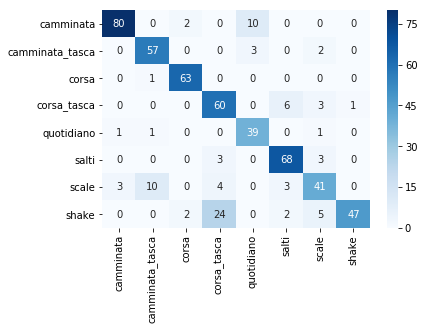

In [89]:
weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
weights[-1] /= peso_shake_qda
weights = weights/weights.sum()
qda = QuadraticDiscriminantAnalysis(priors=weights)
qda.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
y_pred_qda = qda.predict(X_test)
acc_qda_pen = 100*accuracy_score(y_test, y_pred_qda)
print("Accuratezza QDA pesata sull'insieme di test: {:.1f}%".format(acc_qda_pen))
MatriceConfusione(y_test, y_pred_qda,nome_immagine=FIG_PATH+"confusionMatrix-QDA-penalizzata-test")